#### Question 1

a. The last datapoint was released on 26/09/2025.

b. The month being measured was August, 2025.

c. The series is now indexing the latest release as 30/11/2025.

d. The changes in the dates change forecasts by creating lookahead bias. If a forecaster uses data that was not available at the indexed time to train a model, the model will have an unfair advantage and will likely not perform as well in the future.

#### Question 2

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import morethemes as mt
mt.set_theme('economist')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import fredapi as fp

In [54]:
df = pd.read_csv('data.csv')
df.set_index('Date', inplace=True)

##### Part a. 

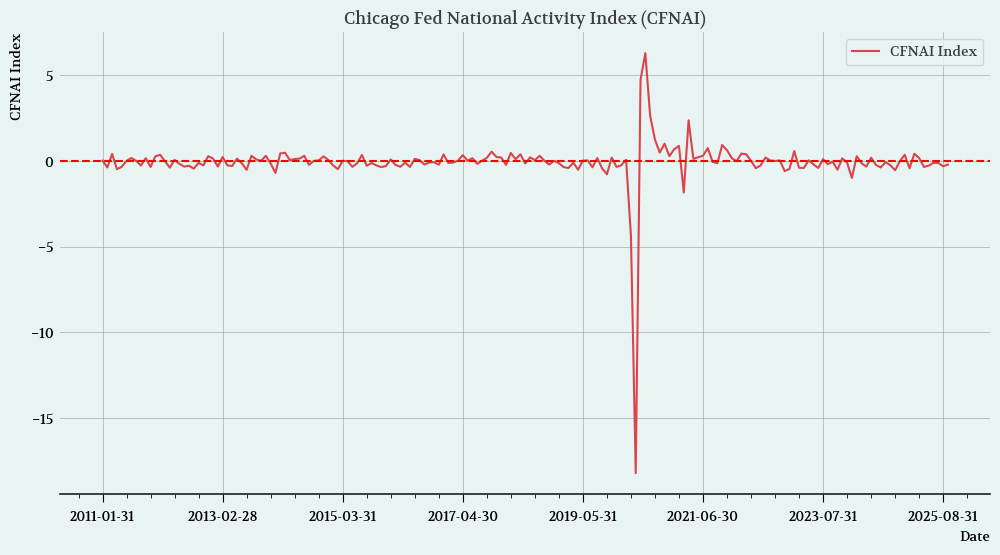

In [ ]:
#GitHub Copilot suggested the labels and title
df.plot(y='CFNAI Index', figsize=(12,6))
plt.title('Chicago Fed National Activity Index (CFNAI)')
plt.xlabel('Date')
plt.ylabel('CFNAI Index')
plt.axhline(0, color='red', linestyle='--')
plt.show()

##### Part b. 
It makes sense to use the CFNAI as a proxy for the output gap because it indicates whether economic activity is above or below its long-run trend. Since potential output is unobservable in real time, CFNAI provides a way to capture deviations from trend. Negative values indicate a negative output gap and positive values indicate a positive one.

#### Question 3

##### Part c.

In [56]:
df['Inflation Gap'] = df['PCE CYOY Index'] - 2.0

##### Part b. 

In [57]:
df['Fed Funds'] = 2 + 0.5 * df['Inflation Gap'] + 0.5 * df['CFNAI Index'].rolling(window=36).mean()

##### Part c. 

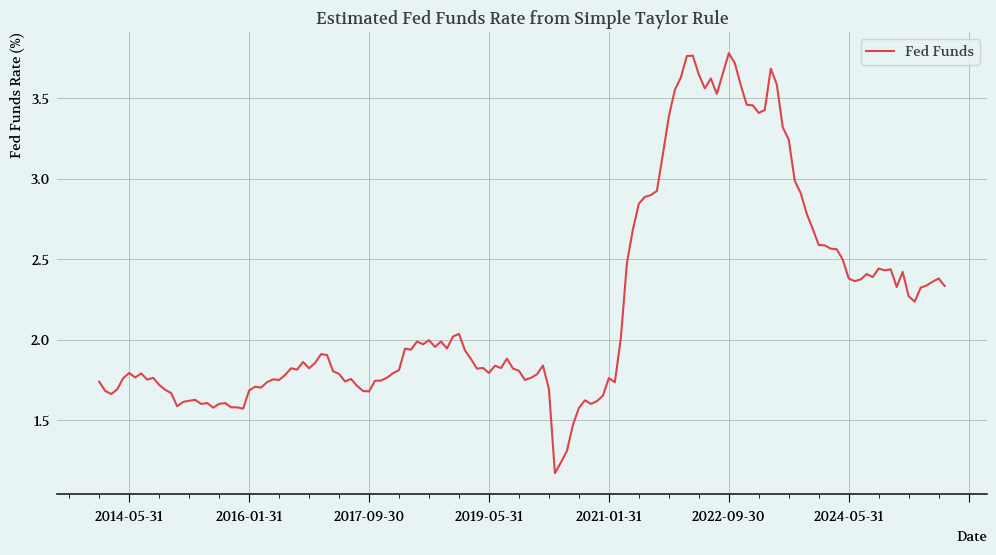

In [ ]:
#GitHub Copilot suggested labels and title
df.plot(y='Fed Funds', figsize=(12,6))
plt.title('Estimated Fed Funds Rate from Simple Taylor Rule')
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate (%)')
plt.show()

#### Question 4
##### Part a.

In [59]:
df.head()

,SHY US Equity,PCE CYOY Index,CFNAI Index,fedfunds,Inflation Gap,Fed Funds
Date,,,,,,
2011-01-31,84.09,1.12345,0.02,0.17,-0.87655,NaN
2011-02-28,83.92,1.21190,-0.38,0.16,-0.78810,NaN
2011-03-31,83.75,1.21457,0.41,0.14,-0.78543,NaN
2011-04-30,84.13,1.39470,-0.48,0.10,-0.60530,NaN
2011-05-31,84.37,1.52357,-0.34,0.09,-0.47643,NaN


In [60]:
# Trading strategy: long SHY if predicted Fed Funds > observed, short otherwise
predicted_col = 'Fed Funds'
observed_col = 'fedfunds'
price_col = 'SHY US Equity'

signal = np.where(df[predicted_col] > df[observed_col], 1, -1)

# One-period holding: apply signal at t to return from t-1 to t
shy_ret = df[price_col].pct_change()
strategy_ret = pd.Series(signal, index=df.index).shift(1) * shy_ret

strategy = pd.DataFrame({
    'signal': signal,
    'shy_ret': shy_ret,
    'strategy_ret': strategy_ret
}, index=df.index)

strategy.head(10)

,signal,shy_ret,strategy_ret
Date,,,
2011-01-31,-1,NaN,NaN
2011-02-28,-1,-0.002022,0.002022
2011-03-31,-1,-0.002026,0.002026
2011-04-30,-1,0.004537,-0.004537
2011-05-31,-1,0.002853,-0.002853
2011-06-30,-1,-0.000830,0.000830
2011-07-31,-1,0.002135,-0.002135
2011-08-31,-1,0.002723,-0.002723
2011-09-30,-1,-0.001653,0.001653


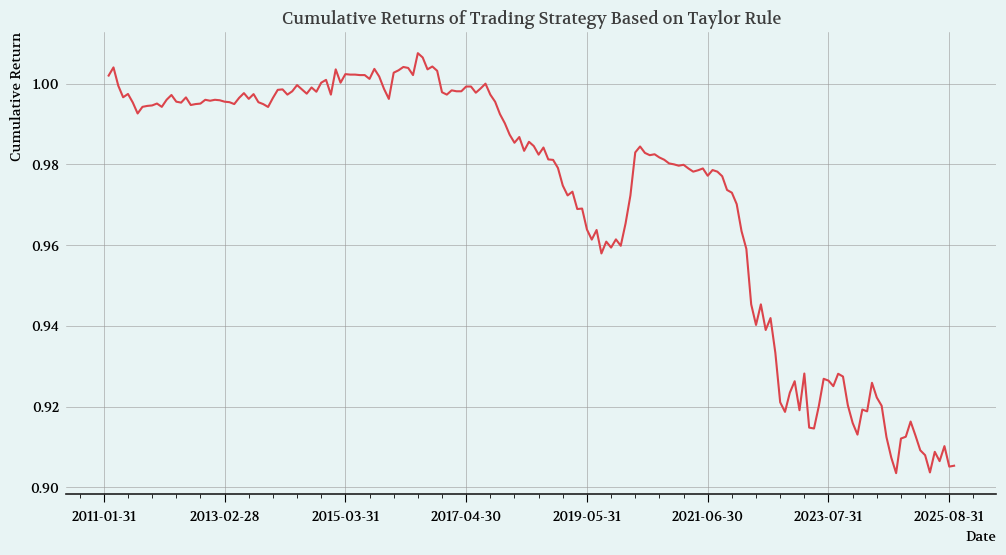

In [62]:
#plot the data
(strategy['strategy_ret'] + 1).cumprod().plot(figsize=(12,6))
plt.title('Cumulative Returns of Trading Strategy Based on Taylor Rule')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [64]:
#calculate annualized return
total_return = (strategy['strategy_ret'] + 1).prod() - 1
date_index = pd.to_datetime(strategy.index)
num_years = (date_index[-1] - date_index[0]).days / 365.25
annualized_return = (1 + total_return) ** (1 / num_years) - 1
annualized_return

np.float64(-0.006759851090103464)

In [65]:
#calculate the skewness of the strategy returns
strategy['strategy_ret'].skew()

np.float64(-0.29972288262658153)